<a href="https://colab.research.google.com/github/smbonilla/learningPyTorch/blob/main/01_pyTorchWorkFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow 

Exploring an example PyTorch end-to-end workflow.

In [48]:
whatWeCover = {1: "data (prepare and load)",
               2: "build model",
               3: "fitting model to data (training)",
               4: "making predictions and evaluating a model (inference)",
               5: "save and loading a model",
               6: "putting it all together"}

whatWeCover

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'save and loading a model',
 6: 'putting it all together'}

In [49]:
import torch 
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt 

# Check PyTorch version
torch.__version__

'1.12.1+cu113'

## 1. Data (preparing and loading)

data can be almost anything in machine learning. 
* excel spreadsheet
* images of any kind
* videos
* audio 
* DNA
* text

machine learning is a game of two parts: 
1. get data into numerical representation
2. build a model to learn patterns in that numerical representation

In [50]:
# create *known* parameters

weight = 0.7 # m in linear regression eq
bias = 0.3 # b in linear regression eq 

start = 0 
end = 1
step = 0.02 

# input (need extra dimension for model later)
X = torch.arange(start, end, step).unsqueeze(dim = 1)

# output 
y = weight * X + bias 

### Splitting data into training and test sets

**very** important sets:
1. training set (70%) **always**
2. validation set - tune model patterns (15%) **often**
3. test set - see if the model is ready for the wild (15%) **always**

Generalization: the ability for a machine learning model to perform well on data it hasn't seen before.

In [51]:
# splitting training and test 

trainSplit = int(0.8*len(X))

XTrain, yTrain = X[:trainSplit], y[:trainSplit] # not random splitting 

XTest, yTest = X[trainSplit:], y[trainSplit:] # not random splitting

len(XTrain), len(yTrain), len(XTest), len(yTest)

(40, 40, 10, 10)

In [52]:
# visualize data 

def plotPredictions(trainData = XTrain,
                    trainLabels = yTrain,
                    testData=XTest,
                    testLabels = yTest, 
                    predictions = None):
  """
  Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(trainData, trainLabels, c="b", s=4, label="TRAINING DATA")

  # plot test data in green 
  plt.scatter(testData, testLabels, c="g", s=4, label="TESTING DATA")

  # are there predictions?
  if predictions is not None:
    
    # plot predictions if exist
    plt.scatter(testData, predictions, c="r", s=4, label="PREDICTED DATA")

  # show the legend
  plt.legend(prop={"size": 14})

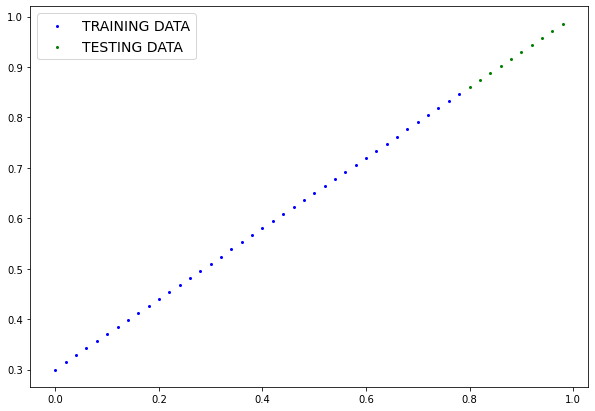

In [53]:
plotPredictions()

## 2. Build model

Our first PyTorch model!

What our model does:
* start with random values for weight & bias
* look at training data and adjust the random values to better represent the ideal values

How does it do this? 
- Two main algorithms:
  1. gradient descent 
  2. backpropagation

In [128]:
# create a linear regression model class 

class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.module
  def __init__(self):
    super().__init__()

    # Initialize model parameters
    self.weights = nn.Parameter(torch.randn(1, # start with a random weight and try to adjust it to ideal weight
                                            requires_grad=True, # can this paramter be updated via gradient descent
                                            dtype=torch.float)) # PyTorch loves the datatype torch.float32
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    
  # forward method to define the computation in the model 
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights*x + self.bias # this is the linear regression formula


### PyTorch model building essentials

* `torch.nn` - contains all of the buildings for computational graphs (a neural network can be considered a computation graph)
* `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - the base class for all neural network modules, if you subclass if, you should overwrite forward()
* `torch.optim` - where the optimizers in PyTorch live, they will help with gradient descent
* `def forward ()` - All `nn.Module` subclasses require you to overwite `forward()` 

### Checking the contents of our PyTorch model

check out our model parameters by using `.parameters()`

In [129]:
# create a random seed 
torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# check our parameters two ways
list(model_0.parameters())

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

to check our model's predictive power, let's see how well it predicts `yTest` based on `XTest`

when we pass data through our model, it's going to run it through `forward()` method

In [130]:
# make predictions with model and can do something similar with torch.no_grad()

with torch.inference_mode(): # when we are doing inference, we are not training so keeping track of less data - no need to track grad
  yPreds = model_0(XTest)

yPreds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

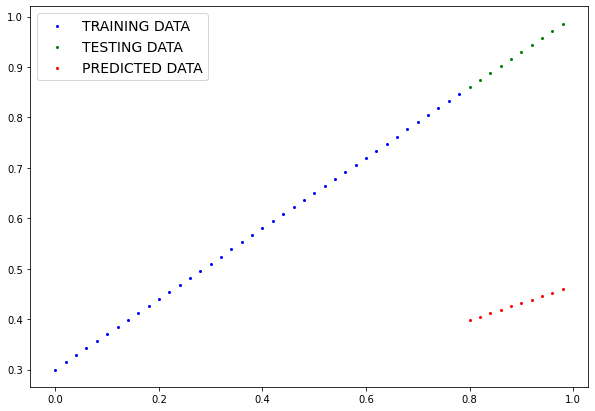

In [131]:
plotPredictions(predictions=yPreds)

## 3. Train model 

The idea of training is for this model to move from *random* parameters to our *known* parameters 
- from a poor representation of the data to a better representation of the data

One way to measure how poor the predictions are is to use a loss function.
* Note: loss function may also be called cost function or criterion in different areas. for our case, we're going to refer to it as a loss function

Things we use to train:
* **Loss function:** a function to measure how wrong your model's predictions are to the ideas outputs, lower is better

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g. weight & bias) to lower the loss

PyTorch, we need:
* a training loop
* a testing loop

In [132]:
# Setup a loss function 
lossFn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(model_0.parameters(), 
                            lr = 0.001) # lr = learning rate -> possibly the most important hyperparameter -> change in parameters

### Building a training loop (and a testing loop) in PyTorch

what do we need:
0. loop through the data
1. forward pass (data moving through our model's `forward()`) to make predictions on data
2. calculate the loss (compare forward pass predictions to ground truth labels)
3. optimize zero grad 
4. loss backward - move backwards through the network to calculate gradients of each parameter (**backpropagation**)
5. optimizer step - use the optimizer to adjust our model's parameters to try and improve loss (**gradient descent**) 

In [138]:
torch.manual_seed(42)

# an Epoch is one loop through the data (this is a hyperparameter because we have set it ourselves)
epochs = 400

# Track different values
epochCount = [] 
lossValues = [] # tracking experiments
testLossValues = [] 

### Training 

# 0. Loop through data
for epoch in range(epochs):

  # set the model to training mode 
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients

  # 1. Forward pass
  yPred = model_0(XTrain)

  # 2. Calculate the loss
  loss = lossFn(yPred,yTrain)

  # 3. Optimizer zero grad
  optimizer.zero_grad() # start fresh so it doesn't accumulate

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will accumulate through the loop, so we have to zero them above in step 3 for the next iteration

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for eval/testing (dropout/batch norm layers)

  with torch.inference_mode(): # turns off gradient tracking 
    
    # 1. Forward pass 
    testPred = model_0(XTest)

    # 2. calculate the loss
    testLoss = lossFn(testPred,yTest)

  # print out what's happening
  if epoch%10 == 0:
    epochCount.append(epoch)
    lossValues.append(loss)
    testLossValues.append(testLoss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {testLoss}")
    print(model_0.state_dict())


Epoch: 0 | Loss: 0.003752306802198291 | Test loss: 0.008672690019011497
OrderedDict([('weights', tensor([0.6815])), ('bias', tensor([0.3078]))])
Epoch: 10 | Loss: 0.0034090480767190456 | Test loss: 0.007913952693343163
OrderedDict([('weights', tensor([0.6832])), ('bias', tensor([0.3070]))])
Epoch: 20 | Loss: 0.0030657730530947447 | Test loss: 0.007086604833602905
OrderedDict([('weights', tensor([0.6849])), ('bias', tensor([0.3063]))])
Epoch: 30 | Loss: 0.0027218691539019346 | Test loss: 0.006259244866669178
OrderedDict([('weights', tensor([0.6866])), ('bias', tensor([0.3056]))])
Epoch: 40 | Loss: 0.0023787864483892918 | Test loss: 0.005500525236129761
OrderedDict([('weights', tensor([0.6883])), ('bias', tensor([0.3049]))])
Epoch: 50 | Loss: 0.002035337733104825 | Test loss: 0.004673170857131481
OrderedDict([('weights', tensor([0.6900])), ('bias', tensor([0.3042]))])
Epoch: 60 | Loss: 0.0016914367442950606 | Test loss: 0.0038457990158349276
OrderedDict([('weights', tensor([0.6918])), ('

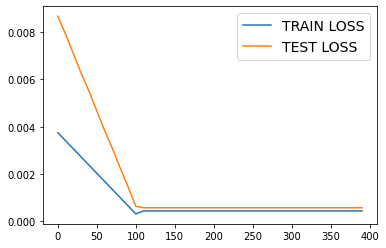

In [139]:
# Plot the loss curves 
import numpy as np
# np.array(torch.tensor(lossValues))

plt.plot(epochCount, np.array(torch.tensor(lossValues)), label="TRAIN LOSS")
plt.plot(epochCount, testLossValues, label ="TEST LOSS")
plt.legend(prop={"size":14})

In [140]:
with torch.inference_mode():
  yPredsNew = model_0(XTest)
  print(model_0.state_dict())

OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])


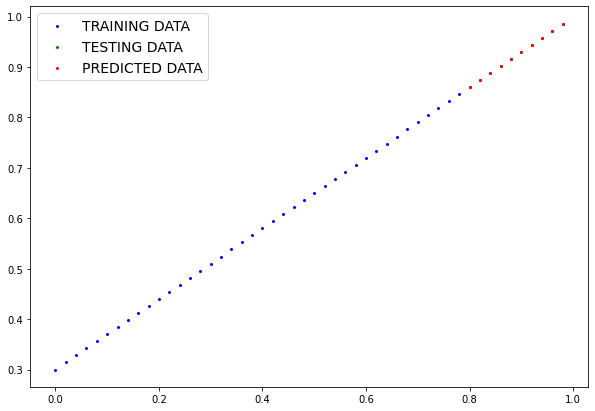

In [141]:
plotPredictions(predictions=yPredsNew)